<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter11/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from torchvision.models import vgg19
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

In [4]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix,model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x


In [5]:
vgg = vgg19_modified().to(device)

C:\Users\hunter\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hunter\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\hunter/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████| 548M/548M [01:05<00:00, 8.82MB/s]


In [6]:
!wget -q https://www.dropbox.com/s/lpw10qawsc5ipbn/MyImage.JPG -O 60.jpg
!wget https://www.dropbox.com/s/1svdliljyo0a98v/style_image.png

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [8]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['style_image.png', '60.jpg']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [9]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [10]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [11]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [12]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]]
content_weights = [1]
weights = style_weights + content_weights

In [13]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [21]:
from torch_snippets.torch_loader import Report
max_iters = 500
optimizer = torch.optim.LBFGS([opt_img])
log = Report(max_iters)

In [22]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 502.000  loss: 1298889.375  (1426.39s - -5.68s remaining))ning)

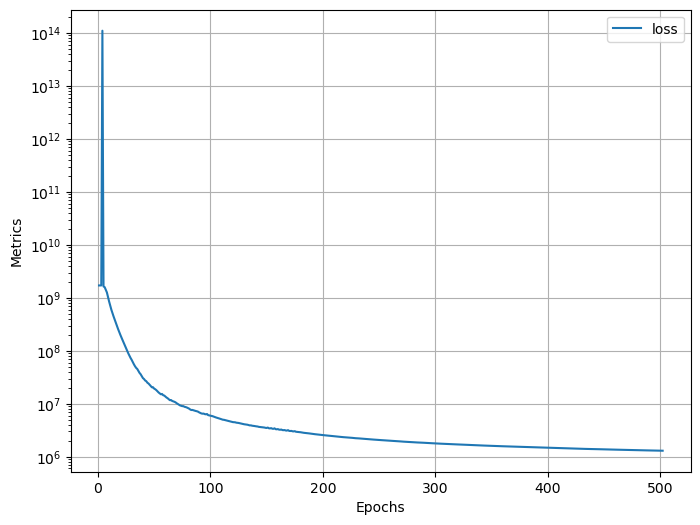

In [23]:
log.plot(log=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


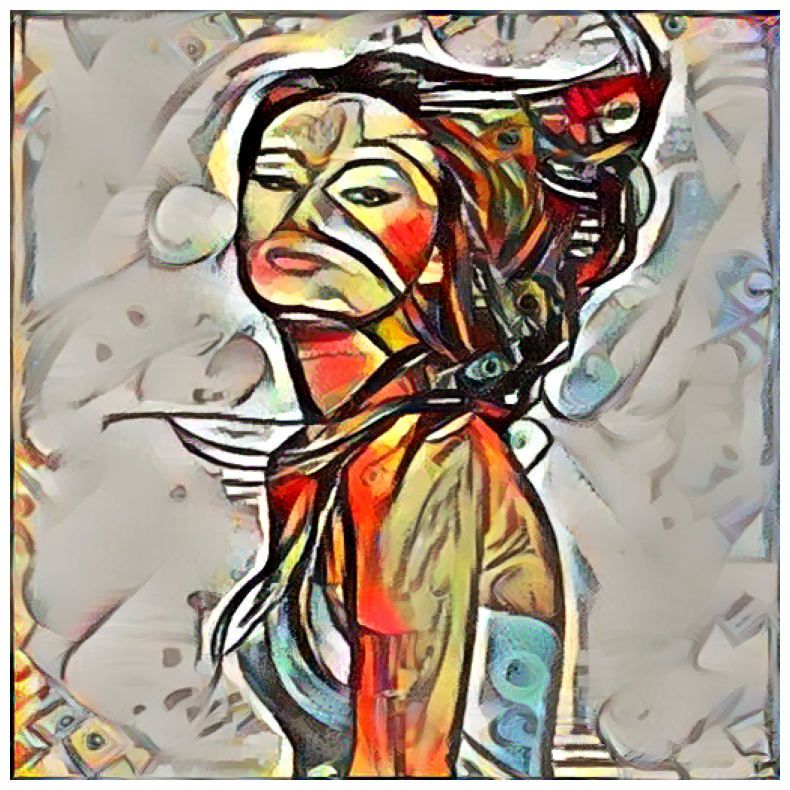

In [24]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)
show(out_img)